In [1]:
from sklearn.datasets import make_blobs

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
N_EPOCHS_CF = 500

# Utils

In [3]:
def get_affected_examples(X, y, label=0):
    X_aff = X.clone()
    X_aff = X_aff[y == label]
    X_aff = X_aff.detach()
    X_aff.requires_grad = True
    cf_dataset = TensorDataset(X_aff)
    cf_dataloader = DataLoader(cf_dataset, batch_size=16)
    return cf_dataloader, X_aff

In [4]:
X, y = make_blobs(n_samples=1000, n_features=2, centers=2, random_state=42)

/var/folders/dy/myfwyf0d73115m920ywglmt80000gn/T/ipykernel_37455/54986738.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


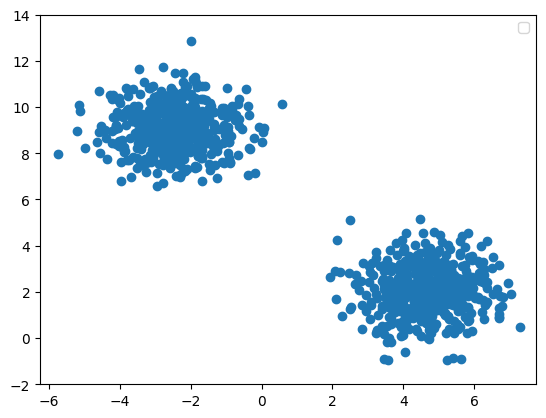

In [5]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1])
plt.legend()
plt.xlim(-6.25, 7.75)
plt.ylim(-2, 14)
plt.show()

# Training model

In [6]:
X, y = torch.tensor(X), torch.tensor(y)

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=16)

In [7]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [8]:
model = LogisticRegression()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [9]:
N_EPOCHS = 500

In [10]:
for _ in range(N_EPOCHS):
    epoch_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = batch
        pred = model(X_batch.float())
        loss = criterion(pred, y_batch.float().reshape(-1, 1))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(epoch_loss)

13.99701414257288
10.77674289047718
8.76254715025425
7.331013582646847
6.237765707075596
5.376873955130577
4.686670925468206
4.125158455222845
3.6622866056859493
3.2761274743825197
2.9504401199519634
2.673033319413662
2.434625718742609
2.228070914745331
2.0477892588824034
1.8893831130117178
1.7493447186425328
1.6248519644141197
1.5136083848774433
1.413734070956707
1.3236749125644565
1.2421402288600802
1.168047464452684
1.1004833448678255
1.038673838134855
0.981958479154855
0.9297708980739117
0.8816235642880201
0.8370950208045542
0.7958156284876168
0.7574670920148492
0.7217666837386787
0.6884667566046119
0.6573501192033291
0.628222263418138
0.6009123353287578
0.5752662401646376
0.5511470548808575
0.5284321713261306
0.5070115448907018
0.48678609216585755
0.46766525064595044
0.44956849748268723
0.4324215871747583
0.41615821118466556
0.40071659930981696
0.386041376972571
0.3720822260947898
0.3587916709948331
0.3461275188019499
0.3340501995990053
0.32252431532833725
0.3115159086883068
0.300

In [11]:
for param in model.parameters():
    param.requires_grad = False

# No freezing

In [12]:
cf_dataloader, X_aff = get_affected_examples(X, y, label=0)
cf_optimizer = optim.Adam([X_aff], lr=0.01)

In [13]:
for _ in range(N_EPOCHS_CF):
    epoch_loss = 0
    for batch in cf_dataloader:
        cf_optimizer.zero_grad()
        X_batch = batch[0]
        X_batch_prev = X_batch.clone().detach()
        pred = model(X_batch.float())
        loss = criterion(pred, torch.ones((X_batch.shape[0], 1), dtype=torch.float32))
        epoch_loss += loss.item()
        loss.backward()
        cf_optimizer.step()
    print(epoch_loss)

848.0393085479736
835.1384468078613
821.5659580230713
806.7265625
790.7699737548828
773.8532276153564
756.2880687713623
738.449254989624
720.5894603729248
702.850715637207
685.3870906829834
668.2243709564209
651.4351787567139
635.0973873138428
619.1493625640869
603.5633201599121
588.2308406829834
573.089072227478
558.1276693344116
543.3006410598755
528.588116645813
513.9911403656006
499.4903573989868
485.11822986602783
470.85647106170654
456.68873596191406
442.60621070861816
428.6031322479248
414.6750078201294
400.8181209564209
387.02966117858887
373.308144569397
359.6538505554199
346.06908798217773
332.5581579208374
319.1270332336426
305.7829074859619
292.53372049331665
279.38783025741577
266.35365200042725
253.43955755233765
240.65368556976318
228.0038514137268
215.49768829345703
203.1430048942566
190.94829273223877
178.92312574386597
167.07834339141846
155.4263379573822
143.98150062561035
132.76092648506165
121.78501319885254
111.07801008224487
100.66850686073303
90.5900068283081
80

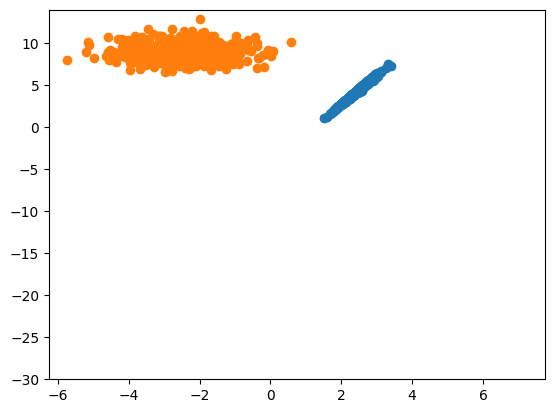

In [14]:
X_aff_vis = X_aff.detach().numpy()
plt.scatter(X_aff_vis[:, 0], X_aff_vis[:, 1])
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1])
plt.xlim(-6.25, 7.75)
plt.ylim(-30, 14)
plt.show()

# Feature freeze

In [15]:
cf_dataloader, X_aff = get_affected_examples(X, y, label=0)
cf_optimizer = optim.Adam([X_aff], lr=0.01)

In [16]:
class FeatureFreeze(torch.autograd.Function):
    freezed_features = []

    @staticmethod
    def forward(ctx, input):
        return input

    @staticmethod
    def backward(ctx, grad_output):
        grad_output[:, 1] = 0

        return grad_output

In [17]:
class FreezeWrapper(nn.Module):
    def __init__(self, model, feature_freeze):
        super().__init__()
        self.feature_freeze = feature_freeze
        self.model = model

    def forward(self, x):
        x = self.feature_freeze.apply(x)
        return self.model(x)

In [18]:
feature_freeze = FeatureFreeze
freezed_features = FreezeWrapper(model, feature_freeze)

In [19]:
for _ in range(N_EPOCHS_CF):
    epoch_loss = 0
    for batch in cf_dataloader:
        cf_optimizer.zero_grad()
        X_batch = batch[0]
        X_batch_prev = X_batch.clone().detach()
        pred = freezed_features(X_batch.float())
        loss = criterion(pred, torch.ones((X_batch.shape[0], 1), dtype=torch.float32))
        epoch_loss += loss.item()
        loss.backward()
        cf_optimizer.step()
    print(epoch_loss)

848.0393085479736
837.917013168335
827.3871555328369
815.999589920044
803.8143825531006
790.9049835205078
777.362060546875
763.3714389801025
749.1457767486572
734.87034034729
720.6457767486572
706.530216217041
692.6466655731201
678.9811115264893
665.5757312774658
652.480806350708
639.7249584197998
627.2282981872559
614.9869346618652
602.9261283874512
591.0026092529297
579.2131195068359
567.5260229110718
555.9219875335693
544.4060115814209
532.9597568511963
521.5907545089722
510.30854320526123
499.09418773651123
487.938440322876
476.83605766296387
465.7836694717407
454.7789354324341
443.82001399993896
432.9053907394409
422.0336570739746
411.2035140991211
400.4137887954712
389.6636199951172
378.95255947113037
368.2807722091675
357.64912509918213
347.05920600891113
336.5133399963379
326.0144319534302
315.5658779144287
305.1713991165161
294.8349657058716
284.56065225601196
274.3525986671448
264.2149109840393
254.15164470672607
244.1667251586914
234.26392602920532
224.44693994522095
214.719

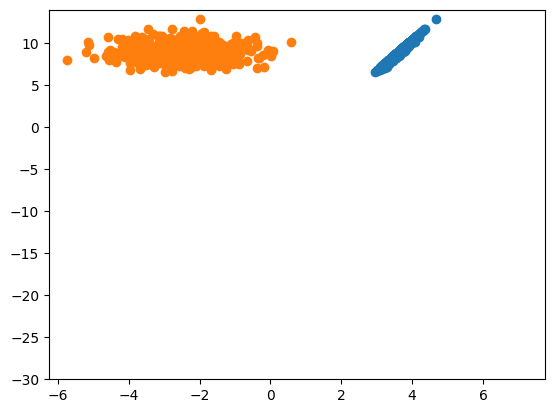

In [20]:
X_aff_vis = X_aff.detach().numpy()
plt.scatter(X_aff_vis[:, 0], X_aff_vis[:, 1])
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1])
plt.xlim(-6.25, 7.75)
plt.ylim(-30, 14)
plt.show()

# Single direction

In [21]:
cf_dataloader, X_aff = get_affected_examples(X, y, label=0)
cf_optimizer = optim.Adam([X_aff], lr=0.01)

In [22]:
class SingleDirection(torch.autograd.Function):
    freezed_features = []

    @staticmethod
    def forward(ctx, input):
        return input

    @staticmethod
    def backward(ctx, grad_output):
        label = 1
        grad_output[:, label] = torch.where(
            grad_output[:, label] < 0, grad_output[:, label], 0
        )

        return grad_output

In [23]:
class SingleDirectionWrapper(nn.Module):
    def __init__(self, model, single_direction):
        super().__init__()
        self.single_direction = single_direction
        self.model = model

    def forward(self, x):
        x = self.single_direction.apply(x)
        return self.model(x)

In [24]:
single_direction = SingleDirection
single_direction_wrapper = SingleDirectionWrapper(model, single_direction)

In [25]:
for _ in range(N_EPOCHS_CF):
    epoch_loss = 0
    for batch in cf_dataloader:
        cf_optimizer.zero_grad()
        X_batch = batch[0]
        X_batch_prev = X_batch.clone().detach()
        pred = single_direction_wrapper(X_batch.float())
        loss = criterion(pred, torch.ones((X_batch.shape[0], 1), dtype=torch.float32))
        epoch_loss += loss.item()
        loss.backward()
        cf_optimizer.step()
    print(epoch_loss)

848.0393085479736
837.917013168335
827.3871555328369
815.999589920044
803.8143825531006
790.9049835205078
777.362060546875
763.3714389801025
749.1457767486572
734.87034034729
720.6457767486572
706.530216217041
692.6466655731201
678.9811115264893
665.5757312774658
652.480806350708
639.7249584197998
627.2282981872559
614.9869346618652
602.9261283874512
591.0026092529297
579.2131195068359
567.5260229110718
555.9219875335693
544.4060115814209
532.9597568511963
521.5907545089722
510.30854320526123
499.09418773651123
487.938440322876
476.83605766296387
465.7836694717407
454.7789354324341
443.82001399993896
432.9053907394409
422.0336570739746
411.2035140991211
400.4137887954712
389.6636199951172
378.95255947113037
368.2807722091675
357.64912509918213
347.05920600891113
336.5133399963379
326.0144319534302
315.5658779144287
305.1713991165161
294.8349657058716
284.56065225601196
274.3525986671448
264.2149109840393
254.15164470672607
244.1667251586914
234.26392602920532
224.44693994522095
214.719

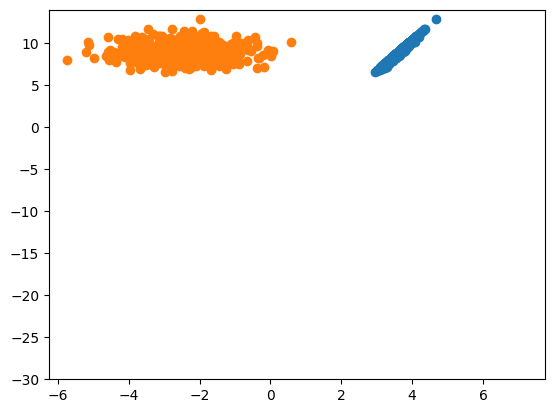

In [26]:
X_aff_vis = X_aff.detach().numpy()
plt.scatter(X_aff_vis[:, 0], X_aff_vis[:, 1])
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1])
plt.xlim(-6.25, 7.75)
plt.ylim(-30, 14)
plt.show()